In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis and preprocessing

In [3]:
# Load the dataset
train_data = pd.read_csv('./archive/train.csv')
train_data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
# print the number of missing values in each column
print(train_data.isnull().sum())

# print the len of the dataset
print(f"Number of training examples: {len(train_data)}")

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64
Number of training examples: 20972


In [10]:
# Calculate the proportion of each category
category_proportions = train_data.iloc[:, 3:].mean()

# Print the proportions to check the values
print(category_proportions)
print(train_data.columns)

Computer Science        0.409784
Physics                 0.286716
Mathematics             0.267881
Statistics              0.248236
Quantitative Biology    0.027990
Quantitative Finance    0.011873
dtype: float64
Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


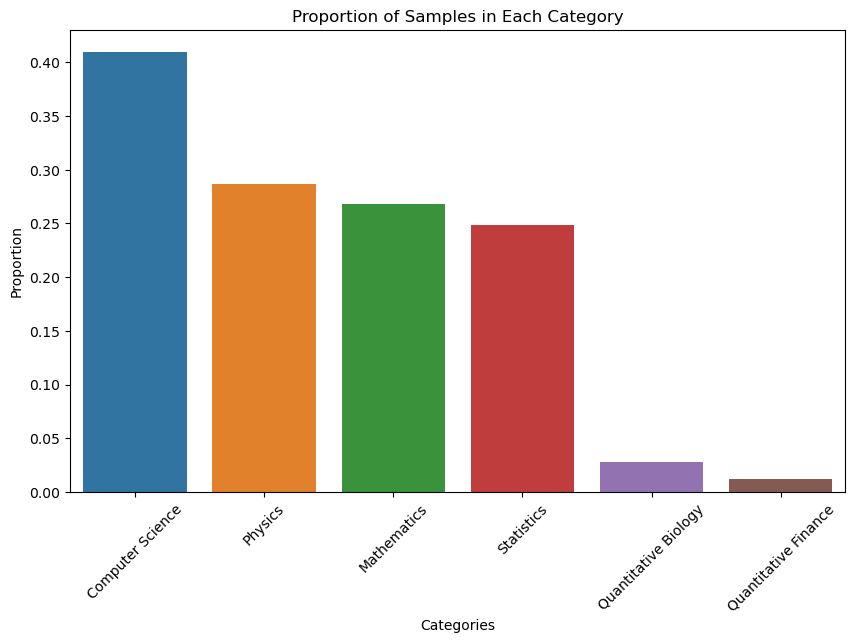

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=category_proportions.index, y=category_proportions.values)
plt.title('Proportion of Samples in Each Category')
plt.ylabel('Proportion')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.show()

we can see that the dataset has not the best distribution of categories, which will affect the accuracy of the model.
But the computer science, physics, mathematics and statistics categories are the most common ones, so the model will be better at predicting these categories.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters (you can tune these)
vocab_size = 10000
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# Combining TITLE and ABSTRACT for the input data
all_text = train_data['TITLE'] + ' ' + train_data['ABSTRACT']

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(all_text)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Prepare target variables
labels = train_data.iloc[:, 3:].values
print(labels)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]]


In [13]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Experimenting with a MLP Model

In [9]:
# if on Apple Silicon M1
from tensorflow.keras.optimizers.legacy import Adam

In [9]:
# otherwise
#from tensorflow.keras.optimizers import Adam

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Model parameters
embedding_dim = 16

# Build the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(labels.shape[1], activation='sigmoid')  # Output layer with one neuron per category
])

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 6)                 150       
                                                                 
Total params: 160558 (627.18 KB)
Trainable params: 160558 (627.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


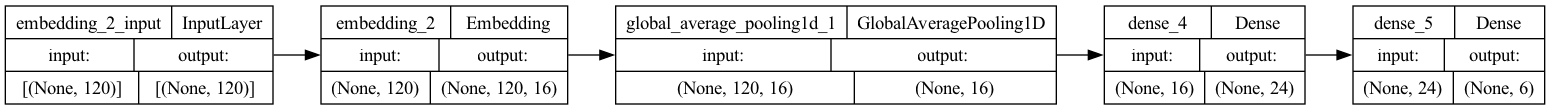

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
# Training parameters
epochs = 20
batch_size = 64

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20


In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# save the model
model.save('research_paper_classification3.keras')

In [ ]:
# evaluate the model in % of accuracy
loss, accuracy = model.evaluate(X_val, y_val, verbose=2)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
from sklearn.metrics import classification_report

# Get binary predictions for the validation set
val_predictions = (model.predict(X_val) > 0.5).astype(int)

# Print classification report
print(classification_report(y_val, val_predictions, target_names=category_names))

# Making Predictions on Test Data

In [3]:
# load the model
from tensorflow.keras.models import load_model

model = load_model('research_paper_classification3.keras', compile=False) # model with the best accuracy 77.33%
model.compile()

2023-12-06 10:29:46.420395: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-06 10:29:46.420416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-06 10:29:46.420422: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-06 10:29:46.420448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 10:29:46.420462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import pandas as pd

# Load the test dataset
test_data = pd.read_csv('archive/test.csv')
# print the len of the dataset
print(f"Number of test examples: {len(test_data)}")

# Combining TITLE and ABSTRACT for the input data
test_text = test_data['TITLE'] + ' ' + test_data['ABSTRACT']

Number of test examples: 8989


In [14]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
# Make predictions
predictions = model.predict(test_padded)

2023-12-06 10:30:22.383378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 1s 3ms/step


In [16]:
# Applying a threshold to convert probabilities to binary values
threshold = 0.5
number_of_papers = 10
binary_predictions = (predictions > threshold).astype(int)

In [17]:
# Displaying the first few binary predictions
print(binary_predictions[:number_of_papers])

[[0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]]


In [18]:
# Assuming you have a list of category names corresponding to the order in your label columns
category_names = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

# Function to map binary predictions to category names
def map_predictions(binary_preds, category_names):
    pred_labels = []
    for pred in binary_preds:
        labels = [category_names[i] for i, val in enumerate(pred) if val == 1]
        pred_labels.append(labels)
    return pred_labels

# Mapping the first few predictions
mapped_predictions = map_predictions(binary_predictions[:number_of_papers], category_names)

# Display mapped predictions
for i, pred in enumerate(mapped_predictions):
    print(f"Test Sample {i+1}: {pred if pred else 'No Categories Predicted'}")

Test Sample 1: ['Statistics']
Test Sample 2: ['Physics']
Test Sample 3: ['Computer Science']
Test Sample 4: ['Physics']
Test Sample 5: ['Computer Science']
Test Sample 6: ['Statistics']
Test Sample 7: ['Mathematics', 'Statistics']
Test Sample 8: ['Physics']
Test Sample 9: ['Computer Science']
Test Sample 10: ['Physics']


In [19]:
# Display predictions with test data for the first few samples
for i in range(number_of_papers):
    print(f"Test Sample {i+1}:")
    print(f"Title: {test_data['TITLE'].iloc[i]}")
    print(f"Abstract: {test_data['ABSTRACT'].iloc[i]}")
    print(f"Predicted Categories: {mapped_predictions[i] if mapped_predictions[i] else 'No Categories Predicted'}")
    print("\n")

Test Sample 1:
Title: Closed-form Marginal Likelihood in Gamma-Poisson Matrix Factorization
Abstract:   We present novel understandings of the Gamma-Poisson (GaP) model, a
probabilistic matrix factorization model for count data. We show that GaP can
be rewritten free of the score/activation matrix. This gives us new insights
about the estimation of the topic/dictionary matrix by maximum marginal
likelihood estimation. In particular, this explains the robustness of this
estimator to over-specified values of the factorization rank, especially its
ability to automatically prune irrelevant dictionary columns, as empirically
observed in previous work. The marginalization of the activation matrix leads
in turn to a new Monte Carlo Expectation-Maximization algorithm with favorable
properties.

Predicted Categories: ['Statistics']


Test Sample 2:
Title: Laboratory mid-IR spectra of equilibrated and igneous meteorites. Searching for observables of planetesimal debris
Abstract:   Meteorites con

In [20]:
# Save predictions in a dataframe
submission_df = pd.DataFrame(columns=['ID'] + category_names)
submission_df['ID'] = test_data['ID'].values
# add title and abstract columns
submission_df['TITLE'] = test_data['TITLE'].values
submission_df['ABSTRACT'] = test_data['ABSTRACT'].values
# add predictions
submission_df[category_names] = binary_predictions

In [21]:
# save the dataframe as excel file
submission_df.to_excel('submission.xlsx', index=False)
# display the dataframe with predictions
submission_df.head(20)

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE,ABSTRACT
0,20973,0,0,0,1,0,0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,0,1,0,0,0,0,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,1,0,0,0,0,0,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,0,1,0,0,0,0,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,1,0,0,0,0,0,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...
5,20978,0,0,0,1,0,0,Pairwise Difference Estimation of High Dimensi...,This paper proposes a regularized pairwise d...
6,20979,0,0,1,1,0,0,Dissecting the multivariate extremal index and...,A central issue in the theory of extreme val...
7,20980,0,1,0,0,0,0,"Big Universe, Big Data: Machine Learning and I...",Astrophysics and cosmology are rich with dat...
8,20981,1,0,0,0,0,0,Natural Language Does Not Emerge 'Naturally' i...,A number of recent works have proposed techn...
9,20982,0,1,0,0,0,0,Properties and Origin of Galaxy Velocity Bias ...,We use the hydrodynamical galaxy formation s...


# Experimenting with a CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Model parameters
vocab_size = 10000
embedding_dim = 128
max_length = 120
num_filters = 128
kernel_size = 5
pool_size = 5
output_units = 6 # number of output units (one for each category)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Conv1D(128, 4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(output_units, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [1]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True, rankdir='LR')

KeyboardInterrupt: 

In [ ]:
# Training parameters
epochs = 10
batch_size = 128

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=1)

In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")